## Introduction

In this project Tweepy will be used to query Twitter's API for data included in the WeRateDogs Twitter archive. This statistics will include the number of retweets and favorites. We create a Twitter application  before executing our API querying code after which we  construct an API object that collects Twitter data. We then write each tweet's JSON data to a tweet json.txt file after querying each tweet ID, with each tweet's JSON data on its own line. We then read this file line by line to generate a pandas DataFrame, then we inspect and clean. 

WeRateDogs is a Twitter account that scores people's pets and includes a funny comment about the dog. The denominator of these scores is generally invariably ten. But what about the denominators? It is almost usually larger than ten. 11/10, 12/10, 13/10, etc.

Simple put, we will gather, assess, and clean data Twitter Data then act on it through analysis, visualization and/or modeling. 

## Gathering

In [74]:
#import required libraries
import pandas as pd
import requests
import os
import tweepy
import config
import time
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
from io import BytesIO
from os import listdir

#### Gather : 
          (1) The WeRateDogs Twitter archive 
          (2) The tweet image predictions
          (3) Additional data from the Twitter API

##### 1. The WeRateDogs Twitter archive 

In [75]:
# Read CSV (comma-separated) file  (The WeRateDogs Twitter archive) into DataFrame
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


##### 2. The tweet image predictions

In [3]:
#url for (The tweet image predictions) image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

Create a folder

In [4]:
#make dir if is does not exist already. 
folder_name = 'wrangle_act'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [5]:
#Using the requests library to get the url(download it) and write it contents to image-predictions.tsv
with open(os.path.join(folder_name, url.split('/')[-1]),
         mode='wb') as file:
    response = requests.get(url)
    file.write(response.content)

In [76]:
#open image_predictions.tsv
df_img_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
df_img_predictions.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### 3. Additional data from the Twitter API

In [8]:
#twitter API consumer_key, consumer_secret, access_token, access_token_secret  imported form config
consumer_key = config.consumer_key
consumer_secret = config.consumer_secret
access_token = config.access_token
access_secret = config.access_secret

In [28]:
# auth = tweepy.OAuth1UserHandler

In [9]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [10]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [11]:
# public_tweets = api.get_followers()
# for tweet in public_tweets:
#     print(tweet.name + ": " + tweet.location)

In [81]:
# Get a list of tweet_ids from the enhanced twitter archive to use for 
# downloading with the Twitter API
tweet_ids = df_twitter_archive.tweet_id.values

In [82]:
#Let Query Twitter's API for the JSON data of each tweet ID in the Twitter archive
index = 0
error_dict = {}
start = time.time()

In [18]:
# Let's save each tweet returned as a new line in a .txt file
with open('tweet_json.txt', 'w') as file:
    for tweet_id in tweet_ids:
        index += 1
        try:
            tweet = api.get_status(tweet_id, tweet_mode ='extended')
            print(str(index) + ": " + "ID- " + str(tweet_id))
            json.dump(tweet._json, file)
            file.write('\n')
            
        except tweepy.TweepyException as error:
            print(str(index) +  ": " + "ID - " + str(tweet_id) + "has an error:", error.response.text)
            # Append the error to the error dict
            error_dict[tweet_id] = error
            
end = time.time()
print(end - start)
            

1: ID- 892420643555336193
2: ID- 892177421306343426
3: ID- 891815181378084864
4: ID- 891689557279858688
5: ID- 891327558926688256
6: ID- 891087950875897856
7: ID- 890971913173991426
8: ID- 890729181411237888
9: ID- 890609185150312448
10: ID- 890240255349198849
11: ID- 890006608113172480
12: ID- 889880896479866881
13: ID- 889665388333682689
14: ID- 889638837579907072
15: ID- 889531135344209921
16: ID- 889278841981685760
17: ID- 888917238123831296
18: ID- 888804989199671297
19: ID- 888554962724278272
20: ID - 888202515573088257has an error: {"errors":[{"code":144,"message":"No status found with that ID."}]}
21: ID- 888078434458587136
22: ID- 887705289381826560
23: ID- 887517139158093824
24: ID- 887473957103951883
25: ID- 887343217045368832
26: ID- 887101392804085760
27: ID- 886983233522544640
28: ID- 886736880519319552
29: ID- 886680336477933568
30: ID- 886366144734445568
31: ID- 886267009285017600
32: ID- 886258384151887873
33: ID- 886054160059072513
34: ID- 885984800019947520
35: ID- 8

260: ID- 843235543001513987
261: ID - 842892208864923648has an error: {"errors":[{"code":144,"message":"No status found with that ID."}]}
262: ID- 842846295480000512
263: ID- 842765311967449089
264: ID- 842535590457499648
265: ID- 842163532590374912
266: ID- 842115215311396866
267: ID- 841833993020538882
268: ID- 841680585030541313
269: ID- 841439858740625411
270: ID- 841320156043304961
271: ID- 841314665196081154
272: ID- 841077006473256960
273: ID- 840761248237133825
274: ID- 840728873075638272
275: ID- 840698636975636481
276: ID- 840696689258311684
277: ID- 840632337062862849
278: ID- 840370681858686976
279: ID- 840268004936019968
280: ID- 839990271299457024
281: ID- 839549326359670784
282: ID- 839290600511926273
283: ID- 839239871831150596
284: ID- 838952994649550848
285: ID- 838921590096166913
286: ID- 838916489579200512
287: ID- 838831947270979586
288: ID- 838561493054533637
289: ID- 838476387338051585
290: ID- 838201503651401729
291: ID- 838150277551247360
292: ID- 8380858393432

Rate limit reached. Sleeping for: 433


308: ID- 835685285446955009
309: ID- 835574547218894849
310: ID- 835536468978302976
311: ID- 835309094223372289
312: ID- 835297930240217089
313: ID- 835264098648616962
314: ID- 835246439529840640
315: ID- 835172783151792128
316: ID- 835152434251116546
317: ID- 834931633769889797
318: ID- 834786237630337024
319: ID- 834574053763584002
320: ID- 834477809192075265
321: ID- 834458053273591808
322: ID- 834209720923721728
323: ID- 834167344700198914
324: ID- 834089966724603904
325: ID- 834086379323871233
326: ID- 833863086058651648
327: ID- 833826103416520705
328: ID- 833732339549220864
329: ID- 833722901757046785
330: ID- 833479644947025920
331: ID- 833124694597443584
332: ID- 832998151111966721
333: ID- 832769181346996225
334: ID- 832757312314028032
335: ID- 832682457690300417
336: ID- 832645525019123713
337: ID- 832636094638288896
338: ID- 832397543355072512
339: ID- 832369877331693569
340: ID- 832273440279240704
341: ID- 832215909146226688
342: ID- 832215726631055365
343: ID- 83208857658

589: ID- 799422933579902976
590: ID- 799308762079035393
591: ID- 799297110730567681
592: ID- 799063482566066176
593: ID- 798933969379225600
594: ID- 798925684722855936
595: ID- 798705661114773508
596: ID- 798701998996647937
597: ID- 798697898615730177
598: ID- 798694562394996736
599: ID- 798686750113755136
600: ID- 798682547630837760
601: ID- 798673117451325440
602: ID- 798665375516884993
603: ID- 798644042770751489
604: ID- 798628517273620480
605: ID- 798585098161549313
606: ID- 798576900688019456
607: ID- 798340744599797760
608: ID- 798209839306514432
609: ID- 797971864723324932
610: ID- 797545162159308800
611: ID- 797236660651966464
612: ID- 797165961484890113
613: ID- 796904159865868288
614: ID- 796865951799083009
615: ID- 796759840936919040
616: ID- 796563435802726400
617: ID- 796484825502875648
618: ID- 796387464403357696
619: ID- 796177847564038144
620: ID- 796149749086875649
621: ID- 796125600683540480
622: ID- 796116448414461957
623: ID- 796080075804475393
624: ID- 79603148629

Rate limit reached. Sleeping for: 502


755: ID- 778764940568104960
756: ID- 778748913645780993
757: ID- 778650543019483137
758: ID- 778624900596654080
759: ID- 778408200802557953
760: ID- 778396591732486144
761: ID- 778383385161035776
762: ID- 778286810187399168
763: ID- 778039087836069888
764: ID- 778027034220126208
765: ID- 777953400541634568
766: ID- 777885040357281792
767: ID- 777684233540206592
768: ID- 777641927919427584
769: ID- 777621514455814149
770: ID- 777189768882946048
771: ID- 776819012571455488
772: ID- 776813020089548800
773: ID- 776477788987613185
774: ID- 776249906839351296
775: ID- 776218204058357768
776: ID- 776201521193218049
777: ID- 776113305656188928
778: ID- 776088319444877312
779: ID- 775898661951791106
780: ID- 775842724423557120
781: ID- 775733305207554048
782: ID- 775729183532220416
783: ID- 775364825476165632
784: ID- 775350846108426240
785: ID - 775096608509886464has an error: {"errors":[{"code":144,"message":"No status found with that ID."}]}
786: ID- 775085132600442880
787: ID- 7747578982368

1026: ID- 746369468511756288
1027: ID- 746131877086527488
1028: ID- 746056683365994496
1029: ID- 745789745784041472
1030: ID- 745712589599014916
1031: ID- 745433870967832576
1032: ID- 745422732645535745
1033: ID- 745314880350101504
1034: ID- 745074613265149952
1035: ID- 745057283344719872
1036: ID- 744995568523612160
1037: ID- 744971049620602880
1038: ID- 744709971296780288
1039: ID- 744334592493166593
1040: ID- 744234799360020481
1041: ID- 744223424764059648
1042: ID- 743980027717509120
1043: ID- 743895849529389061
1044: ID- 743835915802583040
1045: ID- 743609206067040256
1046: ID- 743595368194129920
1047: ID- 743545585370791937
1048: ID- 743510151680958465
1049: ID- 743253157753532416
1050: ID- 743222593470234624
1051: ID- 743210557239623680
1052: ID- 742534281772302336
1053: ID- 742528092657332225
1054: ID- 742465774154047488
1055: ID- 742423170473463808
1056: ID- 742385895052087300
1057: ID- 742161199639494656
1058: ID- 742150209887731712
1059: ID- 741793263812808706
1060: ID- 7417

Rate limit reached. Sleeping for: 525


1202: ID- 716447146686459905
1203: ID- 716439118184652801
1204: ID- 716285507865542656
1205: ID- 716080869887381504
1206: ID- 715928423106027520
1207: ID- 715758151270801409
1208: ID- 715733265223708672
1209: ID- 715704790270025728
1210: ID- 715696743237730304
1211: ID- 715680795826982913
1212: ID- 715360349751484417
1213: ID- 715342466308784130
1214: ID- 715220193576927233
1215: ID- 715200624753819648
1216: ID- 715009755312439296
1217: ID- 714982300363173890
1218: ID- 714962719905021952
1219: ID- 714957620017307648
1220: ID- 714631576617938945
1221: ID- 714606013974974464
1222: ID- 714485234495041536
1223: ID- 714258258790387713
1224: ID- 714251586676113411
1225: ID- 714214115368108032
1226: ID- 714141408463036416
1227: ID- 713919462244790272
1228: ID- 713909862279876608
1229: ID- 713900603437621249
1230: ID- 713761197720473600
1231: ID- 713411074226274305
1232: ID- 713177543487135744
1233: ID- 713175907180089344
1234: ID- 712809025985978368
1235: ID- 712717840512598017
1236: ID- 7126

1485: ID- 693231807727280129
1486: ID- 693155686491000832
1487: ID- 693109034023534592
1488: ID- 693095443459342336
1489: ID- 692919143163629568
1490: ID- 692905862751522816
1491: ID- 692901601640583168
1492: ID- 692894228850999298
1493: ID- 692828166163931137
1494: ID- 692752401762250755
1495: ID- 692568918515392513
1496: ID- 692535307825213440
1497: ID- 692530551048294401
1498: ID- 692423280028966913
1499: ID- 692417313023332352
1500: ID- 692187005137076224
1501: ID- 692158366030913536
1502: ID- 692142790915014657
1503: ID- 692041934689402880
1504: ID- 692017291282812928
1505: ID- 691820333922455552
1506: ID- 691793053716221953
1507: ID- 691756958957883396
1508: ID- 691675652215414786
1509: ID- 691483041324204033
1510: ID- 691459709405118465
1511: ID- 691444869282295808
1512: ID- 691416866452082688
1513: ID- 691321916024623104
1514: ID- 691096613310316544
1515: ID- 691090071332753408
1516: ID- 690989312272396288
1517: ID- 690959652130045952
1518: ID- 690938899477221376
1519: ID- 6909

Rate limit reached. Sleeping for: 562


1646: ID- 683849932751646720
1647: ID- 683834909291606017
1648: ID- 683828599284170753
1649: ID- 683773439333797890
1650: ID- 683742671509258241
1651: ID- 683515932363329536
1652: ID- 683498322573824003
1653: ID- 683481228088049664
1654: ID- 683462770029932544
1655: ID- 683449695444799489
1656: ID- 683391852557561860
1657: ID- 683357973142474752
1658: ID- 683142553609318400
1659: ID- 683111407806746624
1660: ID- 683098815881154561
1661: ID- 683078886620553216
1662: ID- 683030066213818368
1663: ID- 682962037429899265
1664: ID- 682808988178739200
1665: ID- 682788441537560576
1666: ID- 682750546109968385
1667: ID- 682697186228989953
1668: ID- 682662431982772225
1669: ID- 682638830361513985
1670: ID- 682429480204398592
1671: ID- 682406705142087680
1672: ID- 682393905736888321
1673: ID- 682389078323662849
1674: ID- 682303737705140231
1675: ID- 682259524040966145
1676: ID- 682242692827447297
1677: ID- 682088079302213632
1678: ID- 682059653698686977
1679: ID- 682047327939461121
1680: ID- 6820

1926: ID- 674063288070742018
1927: ID- 674053186244734976
1928: ID- 674051556661161984
1929: ID- 674045139690631169
1930: ID- 674042553264685056
1931: ID- 674038233588723717
1932: ID- 674036086168010753
1933: ID- 674024893172875264
1934: ID- 674019345211760640
1935: ID- 674014384960745472
1936: ID- 674008982932058114
1937: ID- 673956914389192708
1938: ID- 673919437611909120
1939: ID- 673906403526995968
1940: ID- 673887867907739649
1941: ID- 673716320723169284
1942: ID- 673715861853720576
1943: ID- 673711475735838725
1944: ID- 673709992831262724
1945: ID- 673708611235921920
1946: ID- 673707060090052608
1947: ID- 673705679337693185
1948: ID- 673700254269775872
1949: ID- 673697980713705472
1950: ID- 673689733134946305
1951: ID- 673688752737402881
1952: ID- 673686845050527744
1953: ID- 673680198160809984
1954: ID- 673662677122719744
1955: ID- 673656262056419329
1956: ID- 673636718965334016
1957: ID- 673612854080196609
1958: ID- 673583129559498752
1959: ID- 673580926094458881
1960: ID- 6735

Rate limit reached. Sleeping for: 552


2092: ID- 670783437142401025
2093: ID- 670782429121134593
2094: ID- 670780561024270336
2095: ID- 670778058496974848
2096: ID- 670764103623966721
2097: ID- 670755717859713024
2098: ID- 670733412878163972
2099: ID- 670727704916926465
2100: ID- 670717338665226240
2101: ID- 670704688707301377
2102: ID- 670691627984359425
2103: ID- 670679630144274432
2104: ID- 670676092097810432
2105: ID- 670668383499735048
2106: ID- 670474236058800128
2107: ID- 670468609693655041
2108: ID- 670465786746662913
2109: ID- 670452855871037440
2110: ID- 670449342516494336
2111: ID- 670444955656130560
2112: ID- 670442337873600512
2113: ID- 670435821946826752
2114: ID- 670434127938719744
2115: ID- 670433248821026816
2116: ID- 670428280563085312
2117: ID- 670427002554466305
2118: ID- 670421925039075328
2119: ID- 670420569653809152
2120: ID- 670417414769758208
2121: ID- 670411370698022913
2122: ID- 670408998013820928
2123: ID- 670403879788544000
2124: ID- 670385711116361728
2125: ID- 670374371102445568
2126: ID- 6703

In [77]:
#Create empty list to convert to DataFrame
df_list = []
#open tweet_json.txt file for reading
with open('tweet_json.txt', encoding='utf-8') as tweet:
    for line in tweet.readlines():
        if line.startswith('{'):
            # Load each tweet lines as JSON string status into a dictionary and reading each line as dictionary
            tweet_line = json.loads(line)
            # Extracting the requied parameters
            tweet_id = tweet_line['id']
            retweet__count = tweet_line['retweet_count']
            favorite__count = tweet_line['favorite_count']
            fellowers__count = tweet_line['user']['followers_count']
            friends__count = tweet_line['user']['friends_count']
            

        
        
            df_list.append({'id': tweet_id,
                        'retweet_count':retweet__count,
                        'favorite_count':favorite__count,
                        'fellowers_count':fellowers__count,
                        'friends_count':friends__count})
    

In [78]:
#Creating the dataFrame
df_tweet = pd.DataFrame(df_list, columns=['id','retweet_count','favorite_count','followers_count','friends_count'])


In [79]:
#display the df_tweet DataFrame
df_tweet

,id,retweet_count,favorite_count,followers_count,friends_count
0,892420643555336193,6991,33760,NaN,21
1,892177421306343426,5293,29278,NaN,21
2,891815181378084864,3471,22025,NaN,21
3,891689557279858688,7208,36855,NaN,21
4,891327558926688256,7742,35237,NaN,21
...,...,...,...,...,...
2322,666049248165822465,36,88,NaN,21
2323,666044226329800704,115,247,NaN,21
2324,666033412701032449,36,100,NaN,21
2325,666029285002620928,39,112,NaN,21


### Accessing Data



The WeRateDogs Twitter archive

In [80]:
#visual inspection of the WeRageDogs Twitter archive
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


The WeRateDogs Twitter archive : df_twitter_archive columns:
* tweet_id: Unique identifier for each tweet
* in_reply_to_status_id	: Identifier of tweers in reply to another tweet
* in_reply_to_user_id : The id of the user whoes tweet was replied
* timestamp	: The time at which the tweet was made
* source : The url of the tweet	
* text: The content of the tweet	
* retweeted_status_id : The id of retweeted tweets	
* retweeted_status_user_id: The user id of a user who retweeted. 	
* retweeted_status_timestamp: The time at which a retweet was made. 	
* expanded_urls	: expanded url of the tweet
* rating_numerator : The rating score of the dog	
* rating_denominator : The base rating score.	
* name: The name of the dog	
* doggo	: A dog phase.  Described as a big "pupper"
* floofer : A dog phase: Ascribed to dogs with seemingly excess fur	
* pupper : A dog phase:  Described as a small "doggo" 	
* puppo :A dog phase . The dog equivalent of a teen

In [81]:
# Random selection of 5 samples for visual accessment  
df_twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2296,667090893657276420,NaN,NaN,2015-11-18 21:23:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Clybe. He is an Anemone Valdez. One ea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667090893...,7,10,Clybe,None,None,None,None
670,789986466051088384,NaN,NaN,2016-10-23 00:27:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Happy. He's a bathtub reviewer. Seems ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789986466...,12,10,Happy,None,None,None,None
1625,684830982659280897,NaN,NaN,2016-01-06 20:16:44 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This little fella really hates stairs. Prefers...,NaN,NaN,NaN,https://vine.co/v/eEZXZI1rqxX,13,10,None,None,None,pupper,None
55,881633300179243008,8.816070e+17,47384430.0,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
823,770069151037685760,NaN,NaN,2016-08-29 01:22:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Carbon. This is his first time sw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770069151...,10,10,Carbon,None,None,None,None


In [82]:
# Lets check for Quality and Tidyness
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [84]:
# Descriptive stats for numerical datat types 
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [85]:
# examine the rating_denominator column
df_twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

The WeRateDogs Twitter archive
#### Quality

* Erroneous datatype assigned `timestamp` and `retweeted_status_timestamp`
* Missing values (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, in_reply_to_status_id, in_reply_to_user_id)
* Incorrect dog names  (e.g., not, a, one, the)
* "None" values in columns instead of null 
* Found 181 retweets. We only want original ratings (no retweets) that have images
* Irrelevant columns to be removed (`in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, and `expanded_urls`.)
* Inconsistent rating denominator at `rating_denominator` column. Rating should be 10. Found min 0 and max 170

#### Tidiness
 * Observations in the `doggo`, `floofer`, `pupper`, and `puppo` columns of the `df_twitter_archive` dataset should be in **one** column which will be a categorical datatype

#### The tweet image predictions

In [248]:
df_img_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


* **tweet_id**: Indiviual tweek key Identifier.
* **jpg_url**: URL to download the images
* **img_num**: Image number that corresponds to the most confident prediction
* **p1**: the first most likely prediction
* **p1_conf**: confident level  of first prediction
* **p1_dog**: outcome of first prediction ; TRUE (dog),FALSE (not dog)
* **p2**: second most likely prediction
* **p2_conf**: confident level of the second prediction
* **p2_dog**: outcome of the second prediction; TRUE (dog), FALSE (not Dog)
* **p3**: the third most likely prediction
* **p3_conf**: confident level  of the third prediction
* **p3_dog**: outcome of first prediction ; TRUE (dog),FALSE (not dog)

In [86]:
df_img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [87]:
df_img_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
758,688789766343622656,https://pbs.twimg.com/media/CY8SocAWsAARuyh.jpg,1,American_Staffordshire_terrier,0.599660,True,Staffordshire_bullterrier,0.380976,True,bull_mastiff,0.003889,True
42,666739327293083650,https://pbs.twimg.com/media/CUC74aTWoAInZey.jpg,1,miniature_poodle,0.546933,True,cocker_spaniel,0.165255,True,toy_poodle,0.095959,True
1872,844979544864018432,https://pbs.twimg.com/media/C7n4aQ0VAAAohkL.jpg,3,tennis_ball,0.999281,False,racket,0.000370,False,Shetland_sheepdog,0.000132,True
583,678800283649069056,https://pbs.twimg.com/media/CWuVQSLW4AAI3w9.jpg,1,Labrador_retriever,0.213673,True,beagle,0.146235,True,Airedale,0.122701,True
571,678399652199309312,https://pbs.twimg.com/ext_tw_video_thumb/67839...,1,swing,0.929196,False,Bedlington_terrier,0.015047,True,Great_Pyrenees,0.014039,True


####  Quality
 * No seperate column for the most accurate dog breed prediction from the theree existing  (`p1`, `p2`, and `p3`) predictions in the `df_img_predictions` (The tweet image predictions) dataset


####  Additional data from the Twitter API

In [88]:
df_tweet

,id,retweet_count,favorite_count,followers_count,friends_count
0,892420643555336193,6991,33760,NaN,21
1,892177421306343426,5293,29278,NaN,21
2,891815181378084864,3471,22025,NaN,21
3,891689557279858688,7208,36855,NaN,21
4,891327558926688256,7742,35237,NaN,21
...,...,...,...,...,...
2322,666049248165822465,36,88,NaN,21
2323,666044226329800704,115,247,NaN,21
2324,666033412701032449,36,100,NaN,21
2325,666029285002620928,39,112,NaN,21


In [89]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2327 non-null   int64  
 1   retweet_count    2327 non-null   int64  
 2   favorite_count   2327 non-null   int64  
 3   followers_count  0 non-null      float64
 4   friends_count    2327 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 91.0 KB


#### Tidiness
* `retweet_count` and `favorite_count` in the `df_tweet` (Additional data from the Twitter API) dataset should be part of the `df_twitter_archive` (The WeRateDogs Twitter archive) dataset.
* `id` column name not consistent with `tweet_id` as found in  `df_img_predictions` and `df_twitter_archive`
* Nomalization is required to merge the tables to a master table for analysis

### Data Cleaning

Let us make a copy of the orignal dataset.

In [90]:
#Let make copy of the original dataset 
# make copies of the original dataframes
twitter_archive_clean = df_twitter_archive.copy()
img_predictions_clean = df_img_predictions.copy()
tweets_clean = df_tweet.copy()

### The WeRateDogs Twitter archive) : twitter_archive_clean

#### Issue:  * "None" values in columns instead of null 

#### Define:
    * Change "None"  values in column and replace them with  `Null`

#### Code

In [91]:
#Change "None"  values in column and replace them with  `Null`
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace('None', np.nan)

#### Test

In [92]:
# Test Change "None"  values in column and replace them with  `Null`
twitter_archive_clean[twitter_archive_clean['name'] == 'None'].count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

In [93]:
## Test Change "None"  values in column and replace them with  `Null`
twitter_archive_clean['name'].sample(5)

141        NaN
2227       NaN
1446       NaN
1848    Bernie
1015       NaN
Name: name, dtype: object

#### Issue : Erroneous datatype assigned `timestamp` and `retweeted_status_timestamp`

#### Define
* Change datatype for `timestamp` and `retweeted_status_timestamp` in (The WeRateDogs Twitter archive) `twitter_archive_clean` to `datatime`

#### Code

In [94]:
#Change datatype for `timestamp` and `retweeted_status_timestamp`in (The WeRateDogs Twitter archive) twitter_archive_clean to datatime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
twitter_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(twitter_archive_clean['retweeted_status_timestamp'])

#### Test

In [95]:

twitter_archive_clean.timestamp.dtype#Test Change  of datatype for `timestamp` in (The WeRateDogs Twitter archive) twitter_archive_clean to datatime

datetime64[ns, UTC]

In [96]:
#Test Change  of datatype for `retweeted_status_timestamp`in (The WeRateDogs Twitter archive) twitter_archive_clean to datatime
twitter_archive_clean.retweeted_status_timestamp.dtype

datetime64[ns, UTC]

#### Issue:  Incorrect dog names  (e.g., not, a, one, the)

#### Define
* Change incorrect dog names (e.g., "not", "a", "one", "the", "quite") and replace them with nan.

#### Code

In [97]:
#Change incorrect dog names (e.g., "not", "a", "one", "the", "quite", 'all') and replace them with nan.
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace("not", np.nan)
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace("a", np.nan)
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace('one', np.nan)
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace("the", np.nan)
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace('quite', np.nan)
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace('all', np.nan)

#### Test

In [98]:
#Confirm that incorrect dog names (e.g., "not", "a", "one", "the", "quite" , "all") are replaced with nan
twitter_archive_clean.query('name == "not" or name == "a" or name == "one" or name == "the" or name == "quite" or name == "all"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Issue:  Found 181 retweets. We only want original ratings (no retweets) that have images

#### Define
* Select and keep only original tweets (no retweets)

#### Code

In [99]:
#Select and keep only original tweets (no retweets)
twitter_archive_clean= twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull() == True]

#### Test

In [100]:
#Test `twitter_archive_clean has  only original tweets (no retweets)
twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull() == False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Issue:   Inconsistent rating denominator at `rating_denominator` column. Rating should be 10. Found min 0 and max 170

#### Define
* Select and Keep only Rating denominator of  10.

#### Code

In [101]:
# #Select and Keep on Rating denominator of  10.
twitter_archive_clean = twitter_archive_clean.query('rating_denominator == 10')

#### Test

In [102]:
#Confirm that all rating denominators are /10
twitter_archive_clean.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Issue:  Irrelevant columns to be removed  (`in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `retweeted_status_id`,                                 `retweeted_status_user_id`, `retweeted_status_timestamp`, and `expanded_urls`.)

#### Define

* Drop Irrelevant columns  (in_reply_to_status_id, in_reply_to_user_id, source, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, and expanded_urls.)

#### Code

In [103]:
# Drop Irrelevant columns  (['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'])
twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis=1, inplace=True)
  

#### Test

In [104]:
#Test that  Irrelevant columns  are droped (['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'])
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

#### Issue: Observations in the `doggo`, `floofer`, `pupper`, and `puppo` columns of the `twitter_archive_clean` dataset should be in **one** column which will be a categorical datatype

#### Define
* Combine observations in the doggo, floofer, pupper, and puppo columns of the twitter_archive_clean dataset into one column which will be a categorical datatype

#### Code

In [105]:
# Combine observations in the doggo, floofer, pupper, and puppo columns
# of the twitter_archive_clean dataset into one column which will be a categorical datatype

# create one column that concatenates values from all dog stages column
twitter_archive_clean['dog_stage'] = twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].agg(' '.join, axis=1)


# extract the correct dog stages from the joined strings
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.str.extract('(doggo|floofer|pupper|puppo)', expand=True)

# change dog stage datatype to category
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].astype('category')


# drop the doggo, floofer, pupper, and puppo columns
twitter_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

#### Test

In [106]:
# Test that we have combined observations in the doggo, floofer, pupper, and puppo columns
# of the twitter_archive_clean dataset into one column which will be a categorical datatype
twitter_archive_clean.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage
582,800388270626521089,2016-11-20 17:20:08+00:00,This is Doc. He takes time out of every day to...,12,10,Doc,floofer
349,831650051525054464,2017-02-14 23:43:18+00:00,"I usually only share these on Friday's, but th...",13,10,NaN,NaN
20,888078434458587136,2017-07-20 16:49:33+00:00,This is Gerald. He was just told he didn't get...,12,10,Gerald,NaN
689,787717603741622272,2016-10-16 18:11:26+00:00,This is Tonks. She is a service puppo. Can hea...,13,10,Tonks,puppo
2102,670679630144274432,2015-11-28 19:04:19+00:00,This is Pluto. He's holding little waddling do...,8,10,Pluto,NaN


In [107]:
# Test that we have combined observations in the doggo, floofer, pupper, and puppo columns
twitter_archive_clean['dog_stage'].value_counts()

pupper     224
doggo       87
puppo       24
floofer      9
Name: dog_stage, dtype: int64

### The tweet image predictions
`img_predictions_clean`:

#### Issue :  * No seperate column for the most accurate dog breed prediction from the theree existing  (`p1`, `p2`, and `p3`) predictions in the `img_predictions_clean` (The tweet image predictions) dataset

#### Define
* select the dog breed with the most confident prediction from among (p1, p2, and p3) predictions in the df_img_predictions (The tweet image predictions) dataset. We assume that p1 is the most confident, followed by p2, and p3). We find conditions where predictions is True and predictions confidents is highest.
* Once we add the `dog_breed_prediction` column  we Drop  columns 'p1',	'p1_conf',	'p1_dog',	'p2',	'p2_conf',	'p2_dog',	'p3', 'p3_conf', 'p3_dog' 

#### Code

In [108]:
#select the dog breed with the most confident prediction from among (p1, p2, and p3)
#predictions in the img_predictions_clean (The tweet image predictions) dataset. 
#Based on observation We assume that p1 is the most confident, followed by p2, and p3).
#We find conditions where predictions is True and predictions confidents is highest. 

conditions = [img_predictions_clean['p1_dog'].eq(True), img_predictions_clean['p2_dog'].eq(True),
              img_predictions_clean['p3_dog'].eq(True)]


# choose choices for each respective condition above
choices = [img_predictions_clean['p1'], img_predictions_clean['p2'], img_predictions_clean['p3']]
# create a dog_breed_predition column that chooses dog breed based on the conditions and choices listed above
img_predictions_clean['dog_breed_prediction'] = np.select(conditions, choices, default=np.nan)

In [109]:
#Once we add the dog_breed_prediction column we Drop columns 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'
# df.drop(['C', 'D'], axis=1)
img_predictions_clean.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

#### Test

In [110]:
# Confirm that column `dog_breed_prediction` with the most confident and True dog breed prediction exists 

img_predictions_clean.head()

,tweet_id,jpg_url,img_num,dog_breed_prediction
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher


### Additional data from the Twitter APItweets_clean`:
`tweets_clean`:

#### Issue :`id` column name not consistent with `tweet_id` as found in  `df_img_predictions` and `twitter_archive_clean

#### Define
* Change id column name  to tweet_id as found in img_predictions_clean and twitter_archive_clean

#### Code

In [111]:
#Change id column name to tweet_id as found in img_predictions_clean and twitter_archive_clean
tweets_clean.rename(columns = {'id' : 'tweet_id'}, inplace=True)

### Test

In [112]:
# Test that id column name has been changed  to tweet_id as found in img_predictions_clean and twitter_archive_clean
tweets_clean.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'followers_count',
       'friends_count'],
      dtype='object')

#### Issue : retweet_count and favorite_count in the tweets_clean (Additional data from the Twitter API) dataset should be part of the `twitter_archive_clean` (The WeRateDogs Twitter archive) dataset.

#### Define

* Create a dataframe from `tweets_clean` with columns `tweet_id`, `retweet_count` and `favorite_count` and merge with `twitter_archive_clean`dataset using inner join

#### Code

In [113]:
#Create a dataframe from tweets_clean with columns tweet_id, retweet_count and favorite_count and merge with twitter_archive_cleandataset using inner join
df_tweet_tomerge = tweets_clean[['tweet_id', 'retweet_count', 'favorite_count']]
twitter_archive_clean = twitter_archive_clean.merge(df_tweet_tomerge, how='inner', on='tweet_id')

#### Test

In [114]:
# Test merge of retweet_count and favorite_count  with twitter_archive_clean dataset
twitter_archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,6991,33760
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,5293,29278
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,3471,22025
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,7208,36855
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,7742,35237


### Issue : Nomalization is required to merge the tables to a master table for analysis

#### Define
* Merge all table columns of intrest into a master dataset

#### Code

In [147]:
#Merge all table columns of intrest into a master dataset

df_master = twitter_archive_clean.merge(img_predictions_clean, on='tweet_id')

#### Test

In [148]:
# Test Merge all table columns of intrest into a master dataset df_master
df_master.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,img_num,dog_breed_prediction
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,6991,33760,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,5293,29278,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,3471,22025,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,7208,36855,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,7742,35237,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset


### Data Storage

At the completetion of data clearning we should store our clean dataset in a new csv file: `twitter_archive_master.csv`

In [121]:
# save the new dataframe to a csv file
df_master.to_csv('twitter_archive_master.csv', index=False)


## Data Analysis

We shall attempt to answer the following questions in our analysis:
* Text with with hightest retweet count
* Which dog stage is the most popular
* Which dog has the most favourite count/ Top Ten Liked Dogs
* Which dogs has the highest number of retweet counts
* top ten dogs with the most retweets,
* relationship between number of likes and retweets,
* top ten rated dogs

    

In [122]:
#load the saved twitter_archive_master.csv
master_df = pd.read_csv('twitter_archive_master.csv')


In [123]:
#number of unque values in each column
master_df.nunique()

tweet_id                1968
timestamp               1968
text                    1968
rating_numerator          20
rating_denominator         1
name                     924
dog_stage                  4
retweet_count           1526
favorite_count          1814
jpg_url                 1968
img_num                    4
dog_breed_prediction     113
dtype: int64

In [124]:
#descriptive statictics 
master_df.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num
count,1.968000e+03,1968.000000,1968.0,1968.000000,1968.000000,1968.000000
mean,7.357836e+17,11.697154,10.0,2237.981199,7708.779472,1.203252
std,6.757143e+16,40.934157,0.0,4011.570859,11371.678533,0.561744
min,6.660209e+17,0.000000,10.0,11.000000,66.000000,1.000000
25%,6.757330e+17,10.000000,10.0,492.750000,1628.500000,1.000000
50%,7.081401e+17,11.000000,10.0,1077.000000,3466.500000,1.000000
75%,7.878678e+17,12.000000,10.0,2559.250000,9554.500000,1.000000
max,8.924206e+17,1776.000000,10.0,70592.000000,144681.000000,4.000000


1 Text with with hightest retweet count

In [125]:
# Text with with hightest retweet count
most_retweet= master_df[master_df['retweet_count'] == master_df['retweet_count'].max()] 
most_retweet.text

765    Here's a doggo realizing you can stand in a po...
Name: text, dtype: object

2 Which dog stage is the most popular

In [126]:
#Which dog stage is the most popular
master_df['dog_stage'].value_counts()

pupper     203
doggo       73
puppo       22
floofer      7
Name: dog_stage, dtype: int64

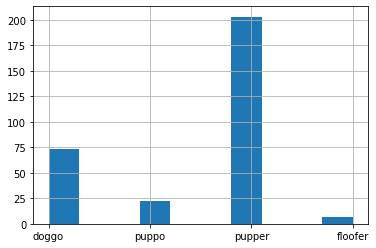

In [127]:
#Which dog stage is the most popular
master_df['dog_stage'].hist();

The graph above shows distribution of dog state.  From this graph pupper a the most popular dog stage 

In [128]:
master_df['dog_breed_prediction'].value_counts()

golden_retriever      154
Labrador_retriever    102
Pembroke               95
Chihuahua              90
pug                    62
                     ... 
Scotch_terrier          1
EntleBucher             1
Japanese_spaniel        1
standard_schnauzer      1
Irish_wolfhound         1
Name: dog_breed_prediction, Length: 113, dtype: int64

 3. Top Ten Liked Dogs

In [129]:
# sort dataframe by favorite_count
favourites = master_df.sort_values(by='favorite_count', axis=0, ascending=False, ignore_index=True)


In [130]:
favourites.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'retweet_count',
       'favorite_count', 'jpg_url', 'img_num', 'dog_breed_prediction'],
      dtype='object')

In [131]:
#select columns 'tweet_id','name','favorite_count','dog_breed_prediction','jpg_url'
favourites = favourites[['tweet_id','name','favorite_count','dog_breed_prediction','jpg_url']]

In [132]:
#Top Ten Liked Dogs with tweet_id, name,favorite_count, dog_breed_prediction, jpg_url
top_ten_liked_dogs = favourites.iloc[0:10]
top_ten_liked_dogs

,tweet_id,name,favorite_count,dog_breed_prediction,jpg_url
0,744234799360020481,NaN,144681,Labrador_retriever,https://pbs.twimg.com/ext_tw_video_thumb/74423...
1,822872901745569793,NaN,123961,Lakeland_terrier,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
2,807106840509214720,Stephan,111529,Chihuahua,https://pbs.twimg.com/ext_tw_video_thumb/80710...
3,866450705531457537,Jamesy,108781,French_bulldog,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg
4,739238157791694849,NaN,107114,Eskimo_dog,https://pbs.twimg.com/ext_tw_video_thumb/73923...
5,879415818425184262,Duddles,92687,English_springer,https://pbs.twimg.com/ext_tw_video_thumb/87941...
6,819004803107983360,Bo,82613,standard_poodle,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg
7,859196978902773760,NaN,80497,malamute,https://pbs.twimg.com/ext_tw_video_thumb/85919...
8,870374049280663552,Zoey,73858,golden_retriever,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg
9,678399652199309312,NaN,73415,Bedlington_terrier,https://pbs.twimg.com/ext_tw_video_thumb/67839...


In [133]:
#top ten liked dogs and predicted dog names
top_ten_liked_dogs.dog_breed_prediction

0    Labrador_retriever
1      Lakeland_terrier
2             Chihuahua
3        French_bulldog
4            Eskimo_dog
5      English_springer
6       standard_poodle
7              malamute
8      golden_retriever
9    Bedlington_terrier
Name: dog_breed_prediction, dtype: object

In [134]:
#save the pictures of the top ten liked dogs 
i = list(range(10))
top_10_liked_folder = 'top_10_liked'
if not os.path.exists(top_10_liked_folder):
    os.makedirs(top_10_liked_folder)
for i in list(top_ten_liked_dogs.index.values):
    top_liked_url = top_ten_liked_dogs['jpg_url'][i]
    top_liked_response = requests.get(top_liked_url)
    top_liked_img = Image.open(BytesIO(top_liked_response.content))
    top_liked_img.save(top_10_liked_folder + "/" + "top_liked_" + str(i) + '.' + 'jpg')      

4 * Which dogs has the highest number of retweet counts

In [135]:
#Which dogs has the highest number of retweet counts  . we sort by rwtweet counts
dogs_retweet_counts = master_df.sort_values(by='retweet_count', ascending=False, axis=0, ignore_index=True)

#select only columns of interest ('tweet_id', 'text',  'name', 'dog_stage', 'retweet_count',
        #'jpg_url', 'img_num', 'dog_breed_prediction')

dogs_retweet_counts = dogs_retweet_counts[['tweet_id', 'text',  'name', 'dog_stage', 'retweet_count',
        'jpg_url', 'img_num', 'dog_breed_prediction']]

In [136]:
#Top 10 dogs with highest number of retweet counts

In [137]:
dogs_retweet_counts = dogs_retweet_counts.iloc[0:10]

In [138]:
dogs_retweet_counts

,tweet_id,text,name,dog_stage,retweet_count,jpg_url,img_num,dog_breed_prediction
0,744234799360020481,Here's a doggo realizing you can stand in a po...,NaN,doggo,70592,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1,Labrador_retriever
1,739238157791694849,Here's a doggo blowing bubbles. It's downright...,NaN,doggo,52818,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1,Eskimo_dog
2,807106840509214720,This is Stephan. He just wants to help. 13/10 ...,Stephan,NaN,51583,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua
3,822872901745569793,Here's a super supportive puppo participating ...,NaN,puppo,39871,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,Lakeland_terrier
4,879415818425184262,This is Duddles. He did an attempt. 13/10 some...,Duddles,NaN,37345,https://pbs.twimg.com/ext_tw_video_thumb/87941...,1,English_springer
5,819004803107983360,This is Bo. He was a very good First Doggo. 14...,Bo,doggo,34508,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle
6,806629075125202948,"""Good afternoon class today we're going to lea...",NaN,NaN,32344,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,cocker_spaniel
7,866450705531457537,This is Jamesy. He gives a kiss to every other...,Jamesy,pupper,30145,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,2,French_bulldog
8,678399652199309312,This made my day. 12/10 please enjoy https://t...,NaN,NaN,28536,https://pbs.twimg.com/ext_tw_video_thumb/67839...,1,Bedlington_terrier
9,676219687039057920,This is Kenneth. He's stuck in a bubble. 10/10...,Kenneth,NaN,27743,https://pbs.twimg.com/media/CWJqN9iWwAAg86R.jpg,1,whippet


5 * Is there any relationship between number of likes and retweets,

In [139]:
# scatter plot of number of likes and retweets

Text(0.5, 1.0, "Number of retweets vs number of likes for WeRateDogs' tweets")

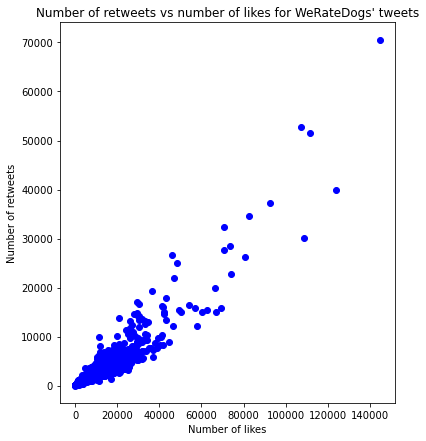

In [140]:


x = master_df['favorite_count']
y = master_df['retweet_count']

plt.figure(figsize=(6,7))
plt.scatter(x,y, color = "blue")

plt.xlabel("Number of likes")
plt.ylabel("Number of retweets")
plt.title("Number of retweets vs number of likes for WeRateDogs' tweets")

The graph above show the Number of retweets vs number of likes for WeRateDogs' tweets. From the graph there is a strong correlation between number of retweets and number of likes

6. * Top ten rated dogs


In [141]:
#Top ten rated dogs
# We sort by rating _numeratior 
top_ten_rated_dogs = master_df.sort_values(by='rating_numerator', ascending=False, axis=0, ignore_index=True )

In [142]:
#Top ten rated dogs by names. 
top_ten_rated_dogs.iloc[0:10].name

0    Atticus
1        NaN
2      Logan
3     Sophie
4        NaN
5      Ollie
6        NaN
7        NaN
8       Iggy
9        NaN
Name: name, dtype: object

In [143]:
#Top ten rated dogs
top_ten_rated_dogs = top_ten_rated_dogs.iloc[0:10]
top_ten_rated_dogs

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,img_num,dog_breed_prediction
0,749981277374128128,2016-07-04 15:00:45+00:00,This is Atticus. He's quite simply America af....,1776,10,Atticus,NaN,2276,4782,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,1,NaN
1,670842764863651840,2015-11-29 05:52:33+00:00,After so many requests... here you go.\n\nGood...,420,10,NaN,NaN,7572,22067,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,1,NaN
2,786709082849828864,2016-10-13 23:23:56+00:00,"This is Logan, the Chow who lived. He solemnly...",75,10,Logan,NaN,5724,17357,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,Pomeranian
3,778027034220126208,2016-09-20 00:24:34+00:00,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10,Sophie,pupper,1492,6192,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber
4,680494726643068929,2015-12-25 21:06:00+00:00,Here we have uncovered an entire battalion of ...,26,10,NaN,NaN,439,1573,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,kuvasz
5,807621403335917568,2016-12-10 16:22:02+00:00,This is Ollie Vue. He was a 3 legged pupper on...,14,10,Ollie,pupper,3381,13842,https://pbs.twimg.com/media/CzU_YVGUUAA3Xsd.jpg,3,golden_retriever
6,685547936038666240,2016-01-08 19:45:39+00:00,Everybody needs to read this. Jack is our firs...,14,10,NaN,pupper,14127,30397,https://pbs.twimg.com/media/CYOONfZW8AA7IOA.jpg,1,NaN
7,884441805382717440,2017-07-10 15:58:53+00:00,"I present to you, Pup in Hat. Pup in Hat is gr...",14,10,NaN,NaN,4785,23830,https://pbs.twimg.com/media/DEYrIZwWsAA2Wo5.jpg,1,Pembroke
8,851464819735769094,2017-04-10 16:00:07+00:00,This is Iggy. He was a rescue dog killed in th...,14,10,Iggy,NaN,6312,22264,https://pbs.twimg.com/media/C9ECujZXsAAPCSM.jpg,2,NaN
9,828650029636317184,2017-02-06 17:02:17+00:00,"Occasionally, we're sent fantastic stories. Th...",14,10,NaN,NaN,1236,8948,https://pbs.twimg.com/media/C3_0yhCWEAETXj2.jpg,1,golden_retriever


In [144]:
#save the pictures of the top ten rated dogs 
i = list(range(10))
top_10_rated_folder = 'top_10_rated'
if not os.path.exists(top_10_rated_folder):
    os.makedirs(top_10_rated_folder)
for i in list(top_ten_rated_dogs.index.values):
    top_rated_url = top_ten_rated_dogs['jpg_url'][i]
    top_rated_response = requests.get(top_rated_url)
    top_rated_img = Image.open(BytesIO(top_rated_response.content))
    top_rated_img.save(top_10_rated_folder + "/" + "top_rated_" + str(i) + '.' + 'jpg')                           
    
                               
                              

In [145]:
master_df[master_df['retweet_count'] == master_df['retweet_count'].max()] 

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,img_num,dog_breed_prediction
765,744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a po...,13,10,NaN,doggo,70592,144681,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1,Labrador_retriever
